In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.feature_selection import RFE

In [2]:
pickle_in = open("indeed_db_v2.pickle", 'rb')
s_v2 = pickle.load(pickle_in)

In [3]:
s_v2

,entreprise,keyword_metier,description,ID,Contract,Location,Salary_type,Salary_clean,Salary,Job_class,...,Num_data_qualities,Data_skills,Num_data_skills,Dev_qualities,Num_dev_qualities,Dev_skills,Num_dev_skills,No_technical_skills,Num_no_technical_skills,Experience
0,badenoch & clark,cyber securité,"localité bordeaux\nbadenoch + clark, cabinet d...",bb1ce865eacc6833,cdi,33,y,65000-75000,70000,0,...,1,[],0,[],0,[],0,"[communication, gestion, anglais]",3,3
1,manpower,cyber securité,l'entreprise\nmanpower cabinet recrutement bor...,81e0457a745c8d29,cdi,33,y,35000-40000,37500,0,...,1,[],0,[],0,[],0,"[communication, gestion]",2,1
2,randstad search,data consultant,randstad search recrute pour un cabinet de con...,e04ee30b5b586da7,cdi,33,y,40000,40000,1,...,0,[tableau],1,[],0,[],0,[gestion],1,1
3,synchrone,data consultant,"votre rôle, vos responsabilités\nnous menons u...",04f8e416e7139d1f,cdi,75,y,25000-50000,37500,1,...,1,[],0,"[cloud, fullstack, mobile]",3,"[css, html, api, java]",4,[agile],1,1
4,synchrone,data consultant,"votre rôle, vos responsabilités\nnous menons u...",ce29173ff827a5a6,cdi,75,y,30000-55000,42500,1,...,0,[python],1,"[cloud, mobile]",2,[],0,[],0,2
5,thélio,data consultant,thelio\net si vous rejoigniez une équipe borde...,9a6cf8c9d5074430,cdi,33,y,45000-55000,50000,1,...,1,"[scala, hadoop, sql, spark, tableau]",5,[],0,"[azure, c]",2,[],0,2
6,thélio,data consultant,thelio\net si vous rejoigniez une équipe borde...,f0722fcbba1401d2,cdi,33,y,35000-45000,40000,1,...,1,"[sql, tableau]",2,[],0,[c],1,"[gestion, management]",2,1
7,thélio,data consultant,thelio\net si vous rejoigniez une équipe borde...,b6a1fec851efd30e,cdi,33,y,35000-45000,40000,1,...,1,[sql],1,[],0,"[azure, c]",2,[gestion],1,1
8,thélio,data consultant,thelio\net si vous rejoigniez une équipe borde...,faff6ea87965d77a,cdi,33,y,35000-45000,40000,1,...,1,"[scala, hadoop, sql, spark, tableau]",5,[],0,"[azure, c]",2,[],0,3
9,synchrone,data consultant,"votre rôle, vos responsabilités\nnous menons u...",41537d2b04c54bff,cdi,75,y,25000-50000,37500,1,...,1,"[spark, python, hive, hadoop]",4,"[cloud, mobile]",2,[php],1,[],0,1


In [4]:
s_v2.columns

Index(['entreprise', 'keyword_metier', 'description', 'ID', 'Contract',
       'Location', 'Salary_type', 'Salary_clean', 'Salary', 'Job_class',
       'Job_title', 'Description', 'Description_filtered', 'Data_qualities',
       'Num_data_qualities', 'Data_skills', 'Num_data_skills', 'Dev_qualities',
       'Num_dev_qualities', 'Dev_skills', 'Num_dev_skills',
       'No_technical_skills', 'Num_no_technical_skills', 'Experience'],
      dtype='object')

In [5]:
oas = s_v2[s_v2['Salary_type'] == 'y']  ####Select job announce with annual salaries

#How many rows of type data
#oas['Job_class'].value_counts()

oas['Salary'] = oas['Salary'].astype('int') ##Convert Salary into integer 

oas = oas[oas['Contract'] != 'contrat pro'] ##Delete contrat pro 
oas.reset_index(drop=True, inplace=True)    ##reset index after dropping rows 
print(oas.shape)

dummy = oas[['Salary', 'description', 'Contract', 'Location', 'Job_class', 'Experience']]  ##Select feature columns

(1669, 24)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Create new columns(features)

In [6]:
###Step1: create new features

In [7]:
###Define a list of skills
all_skills_list = ['data', 'statistique', 'statistics', 'analyse', 'analysis', 'analytics', 'analytiques', \
                   'outils analytiques', 'mathématiques', 'mathematics', 'machine learning', 'ml', \
                   'deep learning', 'dl', 'algorithme', 'algorithm', 'bases de données', 'excel', 'database', \
                   'business intelligence', 'BI', 'intelligence artificielle', 'IA', 'python', 'numpy', \
                   'pandas', 'matplotlib', 'seaborn', 'plotly', 'visualisation','neuron', 'ann', 'cnn', \
                   'lstm', 'keras', 'gan', 'bayesian', 'bayésienne', 'reinforcement learning', 'r', 'shine', \
                   'sql', 'mysql', 'mongo', 'nosql', 'nlp', 'natural language processing', 'sas', 'spark', \
                   'big data', 'hadoop', 'hive', 'mapreduce', 'scala', 'pytorch', 'tensorflow', 'sklearn', \
                   'power bi', 'tableau', 'fullstack', 'full-stack', 'frontend','front-end', 'backend', \
                   'back-end', 'graphics', 'design', 'mobile', 'game', 'test', 'testing', 'cloud', 'cybersecurité', \
                   'javascript','js', 'html','css','java', 'c', 'c#', 'c++', 'swift', 'ruby', 'php', 'docker', \
                   '.net', 'aws', 'azure', 'api', 'wordpress', 'angularjs', 'bootstrap','django', 'jquery', \
                   'symphony', 'frameworks', 'perl', 'xml', 'xhtml','drupal', 'poo', 'oop', 'cms', 'git', \
                   'mobile', 'kotlin', 'objective-c', 'objective c', 'matlab', 'visual basic', 'vb']

In [8]:
###Create bag of words
#Create a list which combines all description 
all_description = []
for i in range(oas.shape[0]):
    for word in oas['Description_filtered'][i]:
        all_description.append(word)

print(len(all_description)) #317051

bag_of_words = Counter(all_description)
print(bag_of_words)

317051
Counter({'développement': 3082, 'équipe': 2613, 'expérience': 2557, 'projets': 1804, 'clients': 1753, 'technique': 1662, 'data': 1621, 'ans': 1610, 'web': 1418, 'profil': 1304, 'cdi': 1291, 'client': 1260, 'données': 1250, 'techniques': 1161, 'solutions': 1152, 'projet': 1126, 'missions': 1113, 'développeur': 1112, 'entreprise': 1109, 'compétences': 1019, 'gestion': 990, 'java': 952, 'environnement': 947, 'type': 939, 'salaire': 927, 'technologies': 922, 'formation': 917, 'outils': 915, 'équipes': 892, 'services': 849, 'informatique': 837, 'applications': 819, 'société': 819, 'mise': 812, 'emploi': 789, 'bac': 783, 'connaissance': 762, 'conception': 748, 'participer': 744, 'travail': 734, 'recherche': 728, 'temps': 725, 'qualité': 721, 'nouvelles': 705, 'intégration': 699, 'travailler': 684, 'net': 680, 'place': 677, 'si': 665, 'agile': 662, 'paris': 662, 'tests': 648, 'faire': 642, 'être': 634, 'ingénieur': 611, 'analyse': 607, 'plein': 606, 'k': 606, 'groupe': 599, 'anglais': 

In [9]:
all_skills_list = ['data', 'données', 'statistique', 'statistics', 'analyser', 'analyse', 'analysis', 'analytics', 'analytiques', \
                   'outils analytiques', 'mathématiques', 'mathematics', 'machine learning', 'ml', \
                   'deep learning', 'dl', 'algorithmes', 'algorithm', 'bases de données', 'excel', 'database', \
                   'business intelligence', 'bi', 'intelligence artificielle', 'ia', 'python', 'numpy', \
                   'pandas', 'matplotlib', 'seaborn', 'plotly', 'visualisation', 'ann', 'cnn', \
                   'lstm', 'keras', 'gan', 'bayesian', 'bayésienne', 'reinforcement learning', 'r', 'shine', \
                   'sql', 'mysql', 'mongo', 'nosql', 'nlp', 'natural language processing', 'sas', 'spark', \
                   'big data', 'hadoop', 'hive', 'mapreduce', 'scala', 'pytorch', 'tensorflow', 'sklearn', \
                   'power bi', 'tableau', 'fullstack', 'full-stack', 'frontend','front-end', 'front end', 'backend', \
                   'back-end', 'back end', 'graphics', 'design', 'mobile', 'game', 'test', 'tests', 'testing', \
                   'maintenance', 'déploiement', 'cloud', 'cybersecurité', \
                   'javascript','js', 'html','css','java', 'c', 'c#', 'c++', 'swift', 'ruby', 'php', 'docker', \
                   '.net', 'aws', 'azure', 'api', 'wordpress', 'angularjs', 'bootstrap','django', 'jquery', \
                   'frameworks', 'perl', 'xml', 'xhtml','drupal', 'poo', 'oop', 'cms', 'git', \
                   'mobile', 'kotlin', 'objective-c', 'objective c', 'matlab', 'visual basic', 'vb']

In [10]:
###According to bag_of_words, add new skills to the skill list. Frequence > 100
##Add some soft skills, company types, industries

all_skills_list2 = ['linux', 'symfony', 'jenkins', 'saas', 'mvc', 'android', 'kubernetes', 'postgresql', \
                    'elasticsearch', 'erp', \
                    'finance', 'assurance', 'transport', 'fintech', 'santé', 'luxe', 'bancaire', \
                    'anglais', 'agile', 'serum', 'international', 'startup']

In [11]:
all_skills_list = all_skills_list + all_skills_list2

In [12]:
len(all_skills_list)

138

# CREATE NEW COLUMNS

In [13]:
for skill in all_skills_list:
    dummy[skill] = 0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
###Extract data from description column

for i in range(dummy.shape[0]):
    for skill_col in all_skills_list:
        if skill_col in dummy['description'][i]:
            dummy[skill_col][i] = 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
###Transform columns of Location and Contract

dummy = pd.get_dummies(dummy, prefix=['Contract', 'Location'], prefix_sep='_', \
                       columns= ['Contract', 'Location'], drop_first=True)   #columns cdd and Location_31 are deleted

In [17]:
dummy.shape

(1669, 148)

In [18]:
dummy = dummy.drop(['description'], axis = 1)

In [19]:
all_skills_list

['data',
 'données',
 'statistique',
 'statistics',
 'analyser',
 'analyse',
 'analysis',
 'analytics',
 'analytiques',
 'outils analytiques',
 'mathématiques',
 'mathematics',
 'machine learning',
 'ml',
 'deep learning',
 'dl',
 'algorithmes',
 'algorithm',
 'bases de données',
 'excel',
 'database',
 'business intelligence',
 'BI',
 'intelligence artificielle',
 'IA',
 'python',
 'numpy',
 'pandas',
 'matplotlib',
 'seaborn',
 'plotly',
 'visualisation',
 'ann',
 'cnn',
 'lstm',
 'keras',
 'gan',
 'bayesian',
 'bayésienne',
 'reinforcement learning',
 'r',
 'shine',
 'sql',
 'mysql',
 'mongo',
 'nosql',
 'nlp',
 'natural language processing',
 'sas',
 'spark',
 'big data',
 'hadoop',
 'hive',
 'mapreduce',
 'scala',
 'pytorch',
 'tensorflow',
 'sklearn',
 'power bi',
 'tableau',
 'fullstack',
 'full-stack',
 'frontend',
 'front-end',
 'front end',
 'backend',
 'back-end',
 'back end',
 'graphics',
 'design',
 'mobile',
 'game',
 'test',
 'tests',
 'testing',
 'maintenance',
 'déploi

In [20]:
##Combine same or similar columns (eng-fr...)
dummy['data'] = dummy['data'] + dummy['données']
dummy['statistique'] = dummy['statistique'] + dummy['statistics'] 
dummy['analyse'] = dummy['analyse'] + dummy['analyser'] + dummy['analysis'] + dummy['analytics'] + dummy['analytiques'] + dummy['outils analytiques']
dummy['mathématiques'] = dummy['mathématiques'] + dummy['mathematics']
dummy['ml'] = dummy['ml'] + dummy['machine learning']
dummy['dl'] = dummy['dl'] + dummy['deep learning']
dummy['algorithmes'] = dummy['algorithmes'] + dummy['algorithm']
dummy['bases de données'] = dummy['bases de données'] + dummy['database']
dummy['BI'] = dummy['BI'] + dummy['business intelligence']
dummy['IA'] = dummy['IA'] + dummy['intelligence artificielle']
dummy['bayésienne'] = dummy['bayésienne'] + dummy['bayesian']
dummy['nlp'] = dummy['nlp'] + dummy['natural language processing']
dummy['fullstack'] = dummy['fullstack'] + dummy['full-stack']
dummy['frontend'] = dummy['frontend'] + dummy['front-end'] + dummy['front end']
dummy['backend'] = dummy['backend'] + dummy['back-end'] + dummy['back end']
dummy['test'] = dummy['test'] + dummy['tests'] + dummy['testing']
dummy['js'] = dummy['js'] + dummy['javascript']
dummy['poo'] = dummy['poo'] + dummy['oop']
dummy['objective-c'] = dummy['objective-c'] + dummy['objective c']

In [21]:
###Drop redundant columns 

dummy = dummy.drop(['données', 'statistics', 'analyser', 'analysis', 'analytics', 'analytiques', 'outils analytiques', \
           'mathematics', 'machine learning', 'deep learning', 'algorithm', 'database', 'business intelligence', \
           'intelligence artificielle', 'bayesian', 'natural language processing', 'full-stack', 'front-end', \
           'front end', 'back-end', 'back end', 'tests', 'testing', 'javascript', 'oop', 'objective c'], axis = 1)


In [22]:
dummy.head() 

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,serum,international,startup,Contract_cdi,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75
0,70000,0,3,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,37500,0,1,1,0,2,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,40000,1,1,2,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,37500,1,1,1,0,2,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,42500,1,2,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [23]:
dummy['Job_class'].sum()

449

In [24]:
###Sum up col values 
dummy = dummy.append(dummy.sum(), ignore_index=True)

###Get index of all columns sum == 0 
index_to_delete = []
for i in range(dummy.shape[1]):
    if dummy.iloc[-1, i] == 0:
        index_to_delete.append(i)
print(index_to_delete) ##[26, 29, 50, 104, 111]

[26, 29, 50, 111]


In [25]:
all_columns = list(dummy.columns)

In [26]:
dummy.columns.get_values()[index_to_delete] #Column names of all columns sum == 0

#dummy.iloc[:, index_to_delete]

array(['bayésienne', 'shine', 'graphics', 'serum'], dtype=object)

In [27]:
selected_columns = [x for x in all_columns if x not in dummy.columns.get_values()[index_to_delete]]

In [28]:
len(selected_columns)

117

In [29]:
##Delete useless columns and the last row of sum 
dummy = dummy[selected_columns]
dummy = dummy.iloc[:1669]

In [30]:
dummy

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,agile,international,startup,Contract_cdi,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75
0,70000,0,3,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,37500,0,1,1,0,2,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,40000,1,1,2,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,37500,1,1,1,0,2,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4,42500,1,2,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,50000,1,2,2,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
6,40000,1,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
7,40000,1,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
8,40000,1,3,2,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
9,37500,1,1,2,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [31]:
dummy.shape

(1669, 117)

In [32]:
###Ignore the frequence, if col name is mentioned, noted as 1; if not, 0
dummy_1 = dummy.iloc[:, 3:].applymap(lambda x: 1 if x > 1 else x)

In [33]:
dummy_1 = pd.concat([dummy[['Salary', 'Job_class', 'Experience']], dummy_1], axis = 1)

In [34]:
# open a file, where you ant to store the data
file = open('dummy_144', 'wb')
# dump information to that file
pickle.dump(dummy_1, file)
# close the file
file.close()

# K-means Clustering
##choose k = 3/4/5

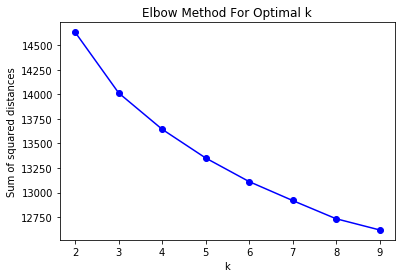

In [35]:
x_kmeans = dummy_1.iloc[:, 1:].values

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans = kmeans.fit(x_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)  #Sum of squared distances of samples to their closest cluster center
    
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#centers = kmeans.cluster_centers_   #cluster_centers_ : Coordinates of cluster centers

In [36]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(x_kmeans)
y_kmeans = kmeans.predict(x_kmeans)

print(y_kmeans)

[1 3 1 ... 2 0 0]


# Test Random Forest 

# Choose the n_cluserting = 4

In [37]:
#Check the range of each category
pd.cut(dummy_1['Salary'], bins = 5, labels = [1, 2, 3, 4, 5], retbins = True)

(0       3
 1       1
 2       2
 3       1
 4       2
 5       2
 6       2
 7       2
 8       2
 9       1
 10      2
 11      1
 12      1
 13      2
 14      2
 15      2
 16      1
 17      2
 18      2
 19      2
 20      4
 21      1
 22      2
 23      1
 24      2
 25      2
 26      2
 27      2
 28      1
 29      1
        ..
 1639    2
 1640    1
 1641    1
 1642    1
 1643    1
 1644    2
 1645    2
 1646    1
 1647    2
 1648    1
 1649    2
 1650    1
 1651    1
 1652    2
 1653    1
 1654    2
 1655    1
 1656    1
 1657    1
 1658    1
 1659    1
 1660    2
 1661    2
 1662    2
 1663    2
 1664    2
 1665    2
 1666    2
 1667    2
 1668    2
 Name: Salary, Length: 1669, dtype: category
 Categories (5, int64): [1 < 2 < 3 < 4 < 5],
 array([ 18025.127,  38501.6  ,  58876.2  ,  79250.8  ,  99625.4  ,
        120000.   ]))

In [38]:
dummy_1['Salary_range_3bins'] = pd.cut(dummy_1['Salary'], bins = 3, labels = [1, 2, 3])
#Categories (3, int64): [1 < 2 < 3],
#array([ 18025.127     ,  52084.66666667,  86042.33333333, 120000.        ]))

dummy_1['Salary_range_4bins'] = pd.cut(dummy_1['Salary'], bins = 4, labels = [1, 2, 3, 4])
#Categories (4, int64): [1 < 2 < 3 < 4],
#array([ 18025.127,  43595.25 ,  69063.5  ,  94531.75 , 120000.   ]))

dummy_1['Salary_range_5bins'] = pd.cut(dummy_1['Salary'], bins = 5, labels = [1, 2, 3, 4, 5])
#array([ 18025.127,  38501.6  ,  58876.2  ,  79250.8  ,  99625.4  , 120000.   ]))

In [39]:
x = dummy_1.iloc[:, 2:-4]
y = dummy_1.iloc[:, -3]

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [41]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=5) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

Best params:  {'max_depth': 6, 'n_estimators': 50}
Random Forest Accuracy:  0.7511961722488039
f1 score:  0.7511961722488039


In [42]:
clf.feature_importances_

array([0.11879609, 0.00750875, 0.00435661, 0.01203333, 0.00500098,
       0.01724847, 0.00735926, 0.01808668, 0.00565093, 0.01340365,
       0.00401771, 0.00431395, 0.05309907, 0.00064382, 0.00202092,
       0.00097281, 0.        , 0.        , 0.00390127, 0.00544505,
       0.        , 0.        , 0.        , 0.00703297, 0.00029629,
       0.        , 0.01194509, 0.00917993, 0.00617568, 0.00319807,
       0.00150376, 0.00294901, 0.02075921, 0.00447062, 0.00594193,
       0.00476512, 0.00238979, 0.03895588, 0.        , 0.00256461,
       0.        , 0.00197688, 0.00143599, 0.00310651, 0.00906191,
       0.00648363, 0.0041126 , 0.01354479, 0.00161008, 0.01676059,
       0.00741024, 0.01017333, 0.02552218, 0.00224156, 0.01034058,
       0.03493938, 0.02116381, 0.01045511, 0.        , 0.0076298 ,
       0.0052092 , 0.00614793, 0.00889226, 0.01314497, 0.00501404,
       0.00633704, 0.05171787, 0.00475803, 0.00777725, 0.00024234,
       0.00109537, 0.00344694, 0.00791225, 0.00393025, 0.00435

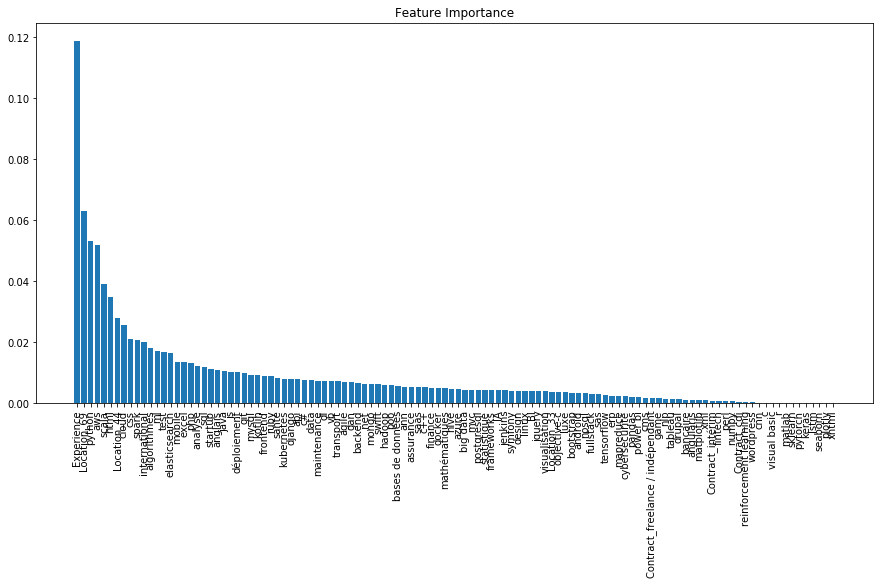

In [43]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [x_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(x_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(x_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [44]:
names

['Experience',
 'Location_69',
 'python',
 'aws',
 'scala',
 'html',
 'Location_44',
 'cloud',
 'css',
 'spark',
 'international',
 'algorithmes',
 'ml',
 'test',
 'elasticsearch',
 'mobile',
 'excel',
 'php',
 'analyse',
 'sql',
 'startup',
 'anglais',
 'java',
 'js',
 'déploiement',
 'git',
 'mysql',
 'kotlin',
 'frontend',
 'ruby',
 'santé',
 'kubernetes',
 'django',
 'api',
 'c#',
 'data',
 'maintenance',
 'dl',
 'vb',
 'transport',
 'agile',
 'gan',
 'backend',
 '.net',
 'mongo',
 'swift',
 'hadoop',
 'poo',
 'bases de données',
 'ann',
 'assurance',
 'saas',
 'c++',
 'finance',
 'docker',
 'mathématiques',
 'hive',
 'azure',
 'big data',
 'mvc',
 'postgresql',
 'statistique',
 'frameworks',
 'IA',
 'jenkins',
 'symfony',
 'design',
 'linux',
 'BI',
 'jquery',
 'visualisation',
 'Location_33',
 'objective-c',
 'luxe',
 'bootstrap',
 'android',
 'nosql',
 'fullstack',
 'sas',
 'tensorflow',
 'erp',
 'mapreduce',
 'cybersecurité',
 'pandas',
 'power bi',
 'cms',
 'Contract_freelance

# First 50 features 

In [45]:
len(names)

114

In [46]:
names50 = names[:50]

In [47]:
dummy_1[names50]

,Experience,Location_69,python,aws,scala,html,Location_44,cloud,css,spark,...,agile,gan,backend,.net,mongo,swift,hadoop,poo,bases de données,ann
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,1,0,1,1,0,...,1,1,1,0,0,0,0,0,0,0
4,2,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,2,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,1,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,1,0,1
9,1,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,1,1,1,0


# 50 Features, elbow method

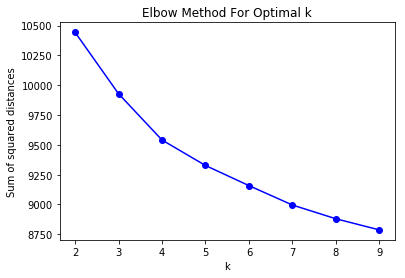

In [48]:
###K-means with 50 features

x_kmeans = dummy_1[names50].values

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans = kmeans.fit(x_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)  #Sum of squared distances of samples to their closest cluster center
    
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# 50 Features,Clustering n = 4, Random Forest 

In [49]:
#add Salary range 4 to the df
dummy_50features = pd.concat([dummy_1[names50], dummy_1['Salary_range_4bins']], axis = 1)

In [50]:
dummy_50features.head()

,Experience,Location_69,python,aws,scala,html,Location_44,cloud,css,spark,...,gan,backend,.net,mongo,swift,hadoop,poo,bases de données,ann,Salary_range_4bins
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,1,0,1,1,0,...,1,1,0,0,0,0,0,0,0,1
4,2,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [51]:
x = dummy_50features.iloc[:, :-2]
y = dummy_50features.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [52]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=5) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best params:  {'max_depth': 5, 'n_estimators': 150}
Random Forest Accuracy:  0.6889952153110048
f1 score:  0.6889952153110048


In [53]:
clf.score(x_train, y_train)

0.6930455635491607

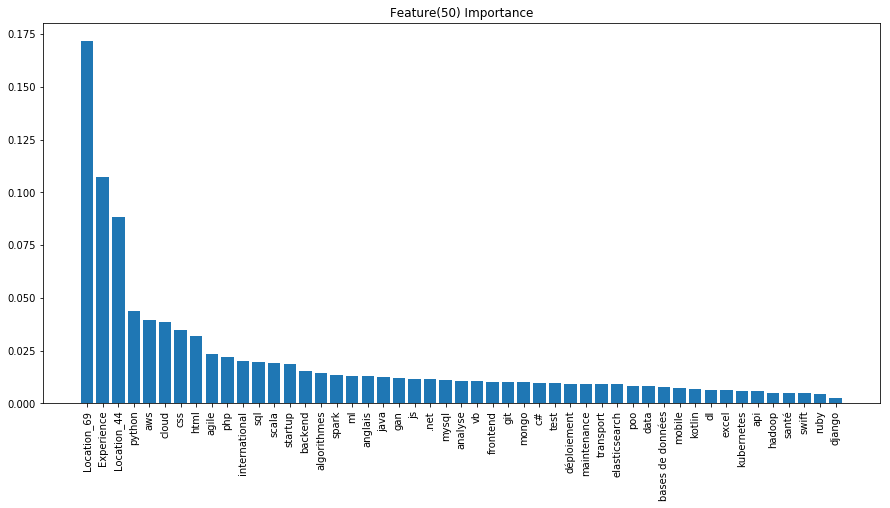

In [54]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [x_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature(50) Importance") # Create plot title
plt.bar(range(x_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(x_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [55]:
#First 80 features

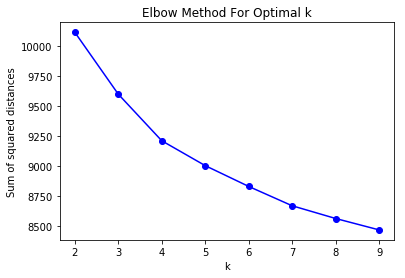

In [56]:
###K-means with 80 features

names80 = names[:80]
x_kmeans = dummy_1[names80].values

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans = kmeans.fit(x_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)  #Sum of squared distances of samples to their closest cluster center
    
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [57]:
#add Salary range 4 to the df
dummy_80features = pd.concat([dummy_1[names80], dummy_1['Salary_range_4bins']], axis = 1)

x = dummy_80features.iloc[:, :-2]
y = dummy_80features.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [58]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=10) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best params:  {'max_depth': 6, 'n_estimators': 150}
Random Forest Accuracy:  0.6818181818181818
f1 score:  0.6818181818181818


In [59]:
clf.score(x_train, y_train)

0.7122302158273381

# Remove outliers

In [60]:
dummy_1['Salary_range_4bins'].value_counts()

2    875
1    716
3     74
4      4
Name: Salary_range_4bins, dtype: int64

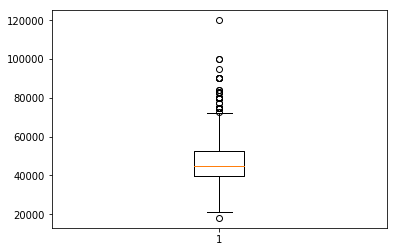

In [61]:
plt.boxplot(dummy_1['Salary'])
plt.show()

In [62]:
Q1 = dummy_1['Salary'].quantile(0.25) 
Q3 = dummy_1['Salary'].quantile(0.75) 
IQR = Q3 - Q1 
print(Q1, Q3, IQR)

outliers_mask = (dummy_1['Salary'] < (Q1-1.5*IQR))|(dummy_1['Salary'] > (Q3+1.5*IQR)) 
print(Q1-1.5*IQR, Q3+1.5*IQR) 

outliers = dummy_1['Salary'][outliers_mask]
print('outliers: ', outliers)
outliers_df = dummy_1[outliers_mask]

39500.0 52500.0 13000.0
20000.0 72000.0
outliers:  20       83100
80       75000
97       75000
120      75000
121      82500
147      72500
170      75000
188      90000
195      75000
204      75000
207      75000
239      77500
277      80000
347      80000
350      80000
355      80000
372      75000
373      90000
377      83100
406      80000
449      80000
571      75000
578      82500
580      80000
586      90000
606      80000
622      95000
623     100000
754      75000
760      75000
954     100000
958      18127
959      77500
968      75000
1002     75000
1009     90000
1010     84000
1020     80000
1023     90000
1034     75000
1052    120000
1055     84000
1361     75000
1386     75000
1502     75000
Name: Salary, dtype: int64


In [63]:
dummy_normal = dummy_1[outliers_mask == False]
dummy_normal = dummy_normal.drop(['Salary_range_4bins', 'Salary_range_3bins', 'Salary_range_5bins'], axis = 1)

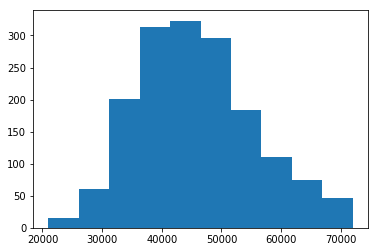

In [64]:
plt.hist(dummy_normal['Salary'])
plt.show()

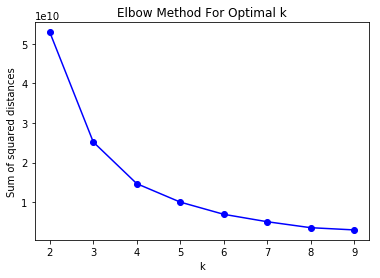

In [65]:
##K-means

x_kmeans = dummy_normal.values

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans = kmeans.fit(x_kmeans)
    sum_of_squared_distances.append(kmeans.inertia_)  #Sum of squared distances of samples to their closest cluster center
    
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Remove outliers, bins = 4

In [66]:
pd.cut(dummy_normal['Salary'], bins = 4, labels = [1, 2, 3, 4], retbins=True)

(0       4
 1       2
 2       2
 3       2
 4       2
 5       3
 6       2
 7       2
 8       2
 9       2
 10      3
 11      1
 12      2
 13      2
 14      2
 15      3
 16      2
 17      2
 18      2
 19      2
 21      2
 22      2
 23      1
 24      3
 25      2
 26      3
 27      3
 28      1
 29      2
 30      1
        ..
 1639    2
 1640    2
 1641    1
 1642    2
 1643    2
 1644    2
 1645    2
 1646    2
 1647    2
 1648    2
 1649    3
 1650    1
 1651    2
 1652    2
 1653    2
 1654    2
 1655    2
 1656    2
 1657    2
 1658    2
 1659    1
 1660    2
 1661    2
 1662    2
 1663    2
 1664    2
 1665    2
 1666    2
 1667    2
 1668    2
 Name: Salary, Length: 1624, dtype: category
 Categories (4, int64): [1 < 2 < 3 < 4],
 array([20949., 33750., 46500., 59250., 72000.]))

In [67]:
dummy_normal.head()

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,agile,international,startup,Contract_cdi,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75
0,70000,0,3,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,37500,0,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,40000,1,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,37500,1,1,1,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4,42500,1,2,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [68]:
dummy_normal['Salary_range_4bins'] = pd.cut(dummy_normal['Salary'], bins = 4, labels = [1, 2, 3, 4])

x = dummy_normal.iloc[:, 1:-2]
y = dummy_normal.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [69]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=10) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

Best params:  {'max_depth': 6, 'n_estimators': 300}
Random Forest Accuracy:  0.5246305418719212
f1 score:  0.5246305418719212


# replace outliers by label 4 (bins = 4)

In [124]:
outliers_min = outliers_df.loc[958]

In [128]:
high_salary_mask = dummy_1['Salary'] > (Q3+1.5*IQR)

In [130]:
high_salary_df = dummy_1[high_salary_mask == True]

In [132]:
high_salary_df.head()

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,Contract_intérim,Location_33,Location_44,Location_69,Location_75,Salary_range_3bins,Salary_range_4bins,Salary_range_5bins,Salary_range_qcut_4bins,Salary_range_qcut_3bins
20,83100,1,3,1,0,1,0,0,0,0,...,0,0,0,0,1,2,3,4,4,3
80,75000,1,1,1,0,0,0,1,1,0,...,0,1,0,0,0,2,3,3,4,3
97,75000,1,2,1,0,0,0,0,0,0,...,0,0,0,0,1,2,3,3,4,3
120,75000,1,2,1,0,0,0,0,0,0,...,0,0,0,0,1,2,3,3,4,3
121,82500,1,3,1,0,1,0,0,0,0,...,0,0,0,0,1,2,3,4,4,3


In [135]:
high_salary_df = high_salary_df.drop(['Salary_range_3bins', 'Salary_range_4bins', 'Salary_range_5bins', \
                     'Salary_range_qcut_4bins', 'Salary_range_qcut_3bins'], axis = 1)

In [136]:
high_salary_df['Salary_range_4bins'] = 4

In [137]:
high_salary_df.head()

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,international,startup,Contract_cdi,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75,Salary_range_4bins
20,83100,1,3,1,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,4
80,75000,1,1,1,0,0,0,1,1,0,...,1,1,1,0,0,1,0,0,0,4
97,75000,1,2,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
120,75000,1,2,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
121,82500,1,3,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4


In [138]:
low_salary_mask = dummy_1['Salary'] < (Q1-1.5*IQR)
low_salary_df = dummy_1[low_salary_mask == True]
low_salary_df = low_salary_df.drop(['Salary_range_3bins', 'Salary_range_4bins', 'Salary_range_5bins', \
                     'Salary_range_qcut_4bins', 'Salary_range_qcut_3bins'], axis = 1)
low_salary_df['Salary_range_4bins'] = 1

In [139]:
low_salary_df

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,international,startup,Contract_cdi,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75,Salary_range_4bins
958,18127,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [140]:
dummy_normal.head()

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,international,startup,Contract_cdi,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75,Salary_range_4bins
0,70000,0,3,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,4
1,37500,0,1,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,2
2,40000,1,1,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,2
3,37500,1,1,1,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,2
4,42500,1,2,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,2


In [142]:
dummy_replace_ouliters = pd.concat([dummy_normal, high_salary_df, low_salary_df], axis = 0)

In [143]:
dummy_replace_ouliters.head()

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,international,startup,Contract_cdi,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75,Salary_range_4bins
0,70000,0,3,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,4
1,37500,0,1,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,2
2,40000,1,1,1,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,2
3,37500,1,1,1,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,2
4,42500,1,2,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,2


In [148]:
x = dummy_replace_ouliters.iloc[:, 1:-1]
y = dummy_replace_ouliters.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [152]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=10) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

Best params:  {'max_depth': 6, 'n_estimators': 400}
Random Forest Accuracy:  0.5334928229665071
f1 score:  0.5334928229665071


# Apply qcut for Salary column

In [92]:
dummy_1['Salary_range_qcut_4bins'] = pd.qcut(dummy_1['Salary'], 4, labels = [1, 2, 3, 4])
dummy_1['Salary_range_qcut_3bins'] = pd.qcut(dummy_1['Salary'], 3, labels = [1, 2, 3])

In [83]:
dummy_1.head()

,Salary,Job_class,Experience,data,statistique,analyse,mathématiques,ml,dl,algorithmes,...,Contract_freelance / indépendant,Contract_intérim,Location_33,Location_44,Location_69,Location_75,Salary_range_3bins,Salary_range_4bins,Salary_range_5bins,Salary_range_qcut_4bins
0,70000,0,3,1,0,1,0,0,0,0,...,0,0,1,0,0,0,2,3,3,4
1,37500,0,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,1,1
2,40000,1,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,2,2
3,37500,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,1,1,1,1,1
4,42500,1,2,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,2,2


In [84]:
pd.qcut(dummy_1['Salary'], 4, labels = [1, 2, 3, 4], retbins=True)

(0       4
 1       1
 2       2
 3       1
 4       2
 5       3
 6       2
 7       2
 8       2
 9       1
 10      4
 11      1
 12      1
 13      2
 14      2
 15      3
 16      1
 17      2
 18      3
 19      3
 20      4
 21      1
 22      2
 23      1
 24      4
 25      2
 26      4
 27      4
 28      1
 29      1
        ..
 1639    2
 1640    1
 1641    1
 1642    1
 1643    1
 1644    2
 1645    2
 1646    1
 1647    2
 1648    1
 1649    3
 1650    1
 1651    1
 1652    2
 1653    1
 1654    2
 1655    1
 1656    1
 1657    1
 1658    1
 1659    1
 1660    2
 1661    2
 1662    2
 1663    2
 1664    2
 1665    2
 1666    2
 1667    2
 1668    2
 Name: Salary, Length: 1669, dtype: category
 Categories (4, int64): [1 < 2 < 3 < 4],
 array([ 18127,  39500,  45000,  52500, 120000]))

In [96]:
dummy_1['Salary_range_qcut_4bins'].value_counts()

2    469
1    426
3    389
4    385
Name: Salary_range_qcut_4bins, dtype: int64

In [97]:
x = dummy_1.iloc[:, 1:-5]
y = dummy_1.iloc[:, -2]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [99]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=10) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best params:  {'max_depth': 6, 'n_estimators': 400}
Random Forest Accuracy:  0.4880382775119617
f1 score:  0.4880382775119617


# qcut = 3

In [153]:
pd.qcut(dummy_1['Salary'], 3, labels = [1, 2, 3], retbins=True)

(0       3
 1       1
 2       1
 3       1
 4       2
 5       2
 6       1
 7       1
 8       1
 9       1
 10      3
 11      1
 12      1
 13      2
 14      1
 15      3
 16      1
 17      1
 18      2
 19      2
 20      3
 21      1
 22      2
 23      1
 24      3
 25      1
 26      3
 27      3
 28      1
 29      1
        ..
 1639    2
 1640    1
 1641    1
 1642    1
 1643    1
 1644    1
 1645    2
 1646    1
 1647    1
 1648    1
 1649    2
 1650    1
 1651    1
 1652    2
 1653    1
 1654    1
 1655    1
 1656    1
 1657    1
 1658    1
 1659    1
 1660    2
 1661    2
 1662    2
 1663    2
 1664    2
 1665    1
 1666    2
 1667    2
 1668    2
 Name: Salary, Length: 1669, dtype: category
 Categories (3, int64): [1 < 2 < 3], array([ 18127,  40000,  50000, 120000]))

In [100]:
dummy_1['Salary_range_qcut_3bins'].value_counts()

2    628
1    572
3    469
Name: Salary_range_qcut_3bins, dtype: int64

In [109]:
x = dummy_1.iloc[:, 1:-5]
y = dummy_1.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [112]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=10) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

Best params:  {'max_depth': 6, 'n_estimators': 50}
Random Forest Accuracy:  0.6004784688995215
f1 score:  0.6004784688995215


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


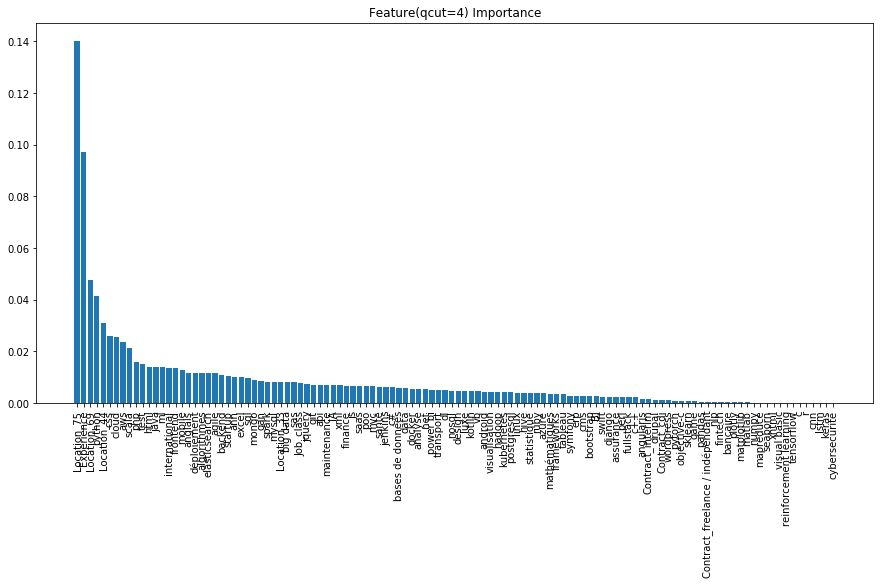

In [115]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [x_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature(qcut=4) Importance") # Create plot title
plt.bar(range(x_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(x_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [114]:
names

['Location_75',
 'Experience',
 'Location_69',
 'python',
 'Location_44',
 'css',
 'cloud',
 'aws',
 'scala',
 'php',
 'test',
 'html',
 'java',
 'ml',
 'international',
 'frontend',
 'mobile',
 'anglais',
 'déploiement',
 'algorithmes',
 'elasticsearch',
 'agile',
 'backend',
 'startup',
 'ann',
 'excel',
 'sql',
 'mongo',
 'gan',
 'spark',
 'mysql',
 'Location_33',
 'big data',
 'sas',
 'Job_class',
 'jquery',
 'git',
 'api',
 'maintenance',
 'IA',
 'xml',
 'finance',
 'js',
 'saas',
 'poo',
 'mvc',
 'santé',
 'jenkins',
 'c#',
 'bases de données',
 'data',
 'docker',
 'analyse',
 '.net',
 'power bi',
 'transport',
 'dl',
 'nosql',
 'design',
 'luxe',
 'kotlin',
 'vb',
 'android',
 'visualisation',
 'hadoop',
 'kubernetes',
 'postgresql',
 'linux',
 'hive',
 'statistique',
 'ruby',
 'azure',
 'mathématiques',
 'frameworks',
 'tableau',
 'symfony',
 'erp',
 'cms',
 'bootstrap',
 'BI',
 'swift',
 'django',
 'assurance',
 'perl',
 'fullstack',
 'c++',
 'angularjs',
 'Contract_intérim',


In [70]:
#Winsorizing data 
from scipy.stats.mstats import winsorize

In [154]:
dummy_1_copy = dummy_1.copy
dummy_1_copy['Salary_winsorize'] = winsorize(dummy_1['Salary'], limits=[0.01, 0.01])

TypeError: 'method' object does not support item assignment

In [ ]:
dummy_1_copy['Salary_winsorize'].max()

In [ ]:
dummy_1_copy['Salary_range_4bins_w'] = pd.cut(dummy_1_copy['Salary_winsorize'], bins = 4, labels = [1, 2, 3, 4])

In [ ]:
dummy_1_copy

In [ ]:
x = dummy_1_copy.iloc[:, 1:-2]
y = dummy_1_copy.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

In [ ]:
clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5, 6]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=10) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

clf = grid_randomforest.best_estimator_
y_pred_randomforest1 = clf.predict(x_test)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)
f1 = f1_score(y_test, y_pred_randomforest, average='micro')
print('f1 score: ', f1)

# n = 3 

In [ ]:
x = dummy_1.iloc[:, 2:-4]
y = dummy_1.iloc[:, -2]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=5)

clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=5) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)

# n = 5

In [ ]:
x = dummy_1.iloc[:, 2:-4]
y = dummy_1.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=5)

clf_randomforest = RandomForestClassifier(random_state=0)
params_randomforest = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],'max_depth': [2, 3, 4, 5]}
grid_randomforest = GridSearchCV(clf_randomforest, params_randomforest, cv=5) 

grid_randomforest.fit(x_train, y_train)
print('Best params: ', grid_randomforest.best_params_)

y_pred_randomforest = grid_randomforest.predict(x_test)

accuracy_randomforest = accuracy_score(y_test, y_pred_randomforest)
print('Random Forest Accuracy: ', accuracy_randomforest)

In [ ]:
#feats = {} # a dict to hold feature_name: feature_importance
#for feature, importance in zip(dummy.columns[1:], clf.feature_importances_):
#    feats[feature] = importance #add the name/value pair 
    
#sorted(feats.items(), key=lambda x: x[1], reverse=True)

In [ ]:
#bag_of_words = dict(bag_of_words)
#bag_of_words_df = pd.DataFrame.from_dict(bag_of_words, orient = 'index', columns = ['times'])
#most_mentioned = bag_of_words_df[bag_of_words_df['times'] > 300]
#bag_of_words_df.sort_values(by=['times'], ascending = False)